# Google Advanced Data Analytics Program: Using Python to Predict Employee Turnover.
By César Perez

## Introduction.

For this exercise we will help a fictional French-based company, Salifort Motors, to design a ML model that predicts whether an employee will leave the company. There is a well know optimal solution for this project using a decision tree algorithm, however, for the sake of exploring an alternative solution to this exercise I will focus on logistic regression, I'll first create a simple model for reference, then, I'll propose a feature engineering approach to enhance the performance.

This notebook is divided in the following sections:
* Introduction.
* Exploratory Data Analysis.
* Model Construction.
* Conclusions.



## Exploratory Data Analysis.

In this section we will explore the dataset. Our goal is to build a general undertanding of the data, then we will use this knowledge to build the best model to predict whether an employee will leave the company or not.

To archieve the business goal, we have been given a single [dataset](https://www.kaggle.com/datasets/mfaisalqureshi/hr-analytics-and-job-prediction?select=HR_comma_sep.csv), there are 14,999 rows, 10 columns, and these variables: 

Variable  |Description |
-----|-----| 
satisfaction_level|Employee-reported job satisfaction level [0&ndash;1]|
last_evaluation|Score of employee's last performance review [0&ndash;1]|
number_project|Number of projects employee contributes to|
average_monthly_hours|Average number of hours employee worked per month|
time_spend_company|How long the employee has been with the company (years)
Work_accident|Whether or not the employee experienced an accident while at work
left|Whether or not the employee left the company
promotion_last_5years|Whether or not the employee was promoted in the last 5 years
Department|The employee's department
salary|The employee's salary (U.S. dollars)

First, lets prepare our work environment, for now lets use Pandas and Numpy for data manipulation, and Matplotlib and seanborn for visuals.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

The data has been provided as a csv file. The following cell will read the data and display basic information about theresulting dataset.

In [2]:
base_df = pd.read_csv('HR_capstone_dataset.csv')
base_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


The following cell displays the first 5 rows.

In [3]:
base_df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


Let's confirm if the data has duplicate rows.

In [4]:
base_df.duplicated().sum()

3008

There are 3008 duplicate entries, given that there is no employee id column or any other feature that can be used to confirm if its possible that two employees have the exact same, salary, tenure, satisfaction score, etc., we'll consider that it is likely that the dataset has errors and thus we'll remove the duplicates.  

In [5]:
base_df.drop_duplicates(inplace = True)

To have an overall understanding of how the numerical data is distributed regardless of the existing departments, let's use the describe method to investigate.

In [6]:
base_df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000
mean,0.629658,0.716683,3.802852,200.473522,3.364857,0.154282,0.166041,0.016929
std,0.241070,0.168343,1.163238,48.727813,1.330240,0.361234,0.372133,0.129012
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.480000,0.570000,3.000000,157.000000,3.000000,0.000000,0.000000,0.000000
50%,0.660000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.860000,5.000000,243.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


Given the business requirement, "left" is our target column. The value 0 (false) represents that an employee has not left the company, while the value 1 (true) represents the opposite, lets see what is the proportion of these two values on the entire dataset. 

In [7]:
base_df['left'].value_counts()

0    10000
1     1991
Name: left, dtype: int64

In [8]:
round(base_df['left'].value_counts(normalize = True) *100,2)

0    83.4
1    16.6
Name: left, dtype: float64

To avoid repetitive code, let's declare some auxiliary functions:
* percentage_analysis: this function will be useful to dinamically create and combine plots representing percentages.
* convert_to_quartile: This function will help us add additional columns to our dataset to simplify the analysis. 

Let's make sure to document our functions in case they have to be used by other members of our team.

In [9]:
def percentage_analysis(df, level_columns, grid_column = None, variable = 'left', label_type = 1, rot = 0):
    """
    Description:
        Returns an horizontal bar plot (barh) and a dataset representing the percentage in value of a selected target variable
    Arguments:
        df: A pandas dataset
        level_columns: a list of strings of existing columns on the dataset (df). The column values are used to compare differences in percentage on the target variable.
        grid_column: a string representing an existing column on the dataset. The column values are used to create subplots. Its use is optional, Default: None
        variable: a string representing an existing column on the dataset, its recomended to use categorical variables. The column represents the target variable being analysed. Default: 'left'.
        label_type: Argument used to configure labeling for the horizontal bars. 0 = no label, 1 = only percentages, 2 = percentages and count. Default: 1.
        rot:  Argument used to configure labeling for the horizontal bars. Integer representing the label text rotation preferred
    """
    subset_output = {}
    df_temp = df.copy()
    levels_variable = df_temp[variable].unique()
    levels_variable.sort()
    if grid_column == None:
        df_temp['temp'] = True
        grid_column = 'temp'
    grid_col = df_temp[grid_column].unique()
    grid_col.sort()
    fig = plt.figure(figsize=(4 * len(level_columns), 7 * len(grid_col)))
    sfigs = fig.subfigures(1, len(level_columns))
    for lcol_indx, sfig in enumerate(sfigs if len(level_columns) > 1 else range(1)):
        if len(level_columns) > 1:
            axs = sfig.subplots(nrows = len(grid_col))
        else:
            axs = sfigs.subplots(nrows = len(grid_col))
        level_col = level_columns[lcol_indx]
        level_col_vals = df_temp[level_col].unique()
        for indx, grid_item in enumerate(grid_col):
            table_dict = {'level':[]}
            for val in levels_variable:
                table_dict[str(val)+'_count'] = []
                table_dict[str(val)+'_percent'] = []
                table_dict[str(val)+'_label'] = []
            for level in level_col_vals:
                table_dict['level'].append(str(level))
                total_level =  df_temp.loc[(df_temp[grid_column]==grid_item)&(df_temp[level_col]==level), level_col].count()
                for val in levels_variable:
                    temp_count = df_temp.loc[(df_temp[grid_column]==grid_item)&(df_temp[level_col]==level)&(df_temp[variable]==val),variable].count()
                    temp_percent = 0 if temp_count == 0 else round(temp_count/(total_level)*100,2)
                    if label_type == 0 or temp_count == 0:
                        temp_label = ''
                    elif label_type == 1:
                        temp_label = str(temp_percent) + '%'
                    elif label_type == 2:
                        temp_label = str(temp_percent) + '% / ' + str(temp_count)
                    table_dict[str(val)+'_count'].append(temp_count)
                    table_dict[str(val)+'_percent'].append(temp_percent)
                    table_dict[str(val)+'_label'].append(temp_label)       
            plot_df = pd.DataFrame(table_dict)
            plot_df.sort_values(by = 'level', ascending = False, inplace = True)
            subset_output[str(level_columns[lcol_indx])+'_'+str(grid_item)] = plot_df.copy()
            plot_df['left_value'] = 0
            if grid_column == 'temp':
                axs.set_title(f'Target variable: {variable}\nPercentage by: {level_col}')
                for val in levels_variable:
                    b1 = axs.barh(plot_df['level'], plot_df[str(val)+'_percent'], left = plot_df['left_value'], label = val)
                    plot_df['left_value'] = plot_df['left_value'] + plot_df[str(val)+'_percent']
                    axs.bar_label(b1, labels = plot_df[str(val)+'_label'], label_type='center', rotation=rot)
                axs.set_ylabel(level_col) 
                leg = axs.legend()

            else:
                axs[indx].set_title(f'Target variable: {variable}\nPercentage by:{level_col}\nSubplot - {grid_column}: {grid_item}')
                for val in levels_variable:
                    b1 = axs[indx].barh(plot_df['level'], plot_df[str(val)+'_percent'], left = plot_df['left_value'], label = val)
                    plot_df['left_value'] = plot_df['left_value'] + plot_df[str(val)+'_percent']
                    axs[indx].bar_label(b1, labels = plot_df[str(val)+'_label'], label_type='center', rotation=rot)
                axs[indx].set_ylabel(level_col) 
                leg = axs[indx].legend()
    return fig, subset_output

def convert_to_quartile(df, target_col = []):
    """
    Description:
        Adds to a provided pandas dataframe, columns representing the quartile value of the selected numerical columns.
        The new inserted columns will include the values:
            1. min to 24.9%
            2. 25% to 49.9%
            3. 50% to 74.9%
            4. 75% to max.
        The new columns will be named as: column name + '_quartile'
    Arguments:
        df: A pandas dataset
        target_col: a list of string representing the columns to be trnsformed to quartile value
    """
    extended_df = df.copy()
    quartiles_list = [0, 0.25, 0.50, 0.75]
    for col in target_col:
        col_name = col + '_quartile'
        for indx, quantile in enumerate(quartiles_list):
            min_val = quantile
            max_val = 1 if quantile == 0.75 else quartiles_list[indx+1]
            extended_df.loc[(extended_df[col] >= extended_df[col].quantile(min_val)) & (extended_df[col] <= extended_df[col].quantile(max_val)),col_name] = indx+1
    return extended_df

def convert_to_zscore(df, target_col = []):
    """
    Description:
        Adds to a provided pandas dataframe, columns representing the z-score value of the selected numerical columns.
        The new columns will be named as: column name + '_standardized'
    Arguments:
        df: A pandas dataset
        target_col: a list of string representing the columns to be trnsformed to quartile value
    """
    extended_df = df.copy()
    for col in target_col:
        col_name = col + '_standardized'
        extended_df[col_name] = (extended_df[col] -extended_df[col].mean()) / extended_df[col].std() 
    return extended_df

Let's confirm how other data professionals would visualize the brief documetation we have included in our functions.

In [10]:
help(percentage_analysis)

Help on function percentage_analysis in module __main__:

percentage_analysis(df, level_columns, grid_column=None, variable='left', label_type=1, rot=0)
    Description:
        Returns an horizontal bar plot (barh) and a dataset representing the percentage in value of a selected target variable
    Arguments:
        df: A pandas dataset
        level_columns: a list of strings of existing columns on the dataset (df). The column values are used to compare differences in percentage on the target variable.
        grid_column: a string representing an existing column on the dataset. The column values are used to create subplots. Its use is optional, Default: None
        variable: a string representing an existing column on the dataset, its recomended to use categorical variables. The column represents the target variable being analysed. Default: 'left'.
        label_type: Argument used to configure labeling for the horizontal bars. 0 = no label, 1 = only percentages, 2 = percentages a

In [11]:
help(convert_to_quartile)

Help on function convert_to_quartile in module __main__:

convert_to_quartile(df, target_col=[])
    Description:
        Adds to a provided pandas dataframe, columns representing the quartile value of the selected numerical columns.
        The new inserted columns will include the values:
            1. min to 24.9%
            2. 25% to 49.9%
            3. 50% to 74.9%
            4. 75% to max.
        The new columns will be named as: column name + '_quartile'
    Arguments:
        df: A pandas dataset
        target_col: a list of string representing the columns to be trnsformed to quartile value



In [12]:
help(convert_to_zscore)

Help on function convert_to_zscore in module __main__:

convert_to_zscore(df, target_col=[])
    Description:
        Adds to a provided pandas dataframe, columns representing the z-score value of the selected numerical columns.
        The new columns will be named as: column name + '_standardized'
    Arguments:
        df: A pandas dataset
        target_col: a list of string representing the columns to be trnsformed to quartile value



Let's add the extra quartile columns to our dataset and display the first rows to see the results.

In [13]:
base_df_2 = convert_to_quartile(base_df, ['satisfaction_level', 'last_evaluation', 'average_montly_hours', 'time_spend_company'])
base_df_2.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary,satisfaction_level_quartile,last_evaluation_quartile,average_montly_hours_quartile,time_spend_company_quartile
0,0.38,0.53,2,157,3,0,1,0,sales,low,1.0,1.0,2.0,3.0
1,0.80,0.86,5,262,6,0,1,0,sales,medium,3.0,4.0,4.0,4.0
2,0.11,0.88,7,272,4,0,1,0,sales,medium,1.0,4.0,4.0,4.0
3,0.72,0.87,5,223,5,0,1,0,sales,low,3.0,4.0,3.0,4.0
4,0.37,0.52,2,159,3,0,1,0,sales,low,1.0,1.0,2.0,3.0


Let's confirm the function convert_to_quartile is consistent with the output the describe method used earlier.

In [14]:
base_df_2.groupby('satisfaction_level_quartile').agg({'satisfaction_level':['min', 'max', 'mean', 'count']})

satisfaction_level                      
                                           min   max      mean count
satisfaction_level_quartile                                         
1.0                                       0.09  0.47  0.286134  2887
2.0                                       0.48  0.65  0.566255  3020
3.0                                       0.66  0.81  0.736552  2918
4.0                                       0.82  1.00  0.904867  3166

satisfaction_level_quartile looks good, let's now convert 'time_spend_company'.

In [15]:
base_df_2.groupby('time_spend_company_quartile').agg({'time_spend_company':['min', 'max', 'mean', 'count']})

time_spend_company                    
                                           min max      mean count
time_spend_company_quartile                                       
1.0                                          2   2  2.000000  2910
3.0                                          3   3  3.000000  5190
4.0                                          4  10  4.872269  3891

It looks like our function is showing a weird behaviour here, its missing the second range, this can only happen because quartiles 0.25 and 0.70 have the same value and thus the label gets overwritten. See the output of the describe fuction for this column above. Let's capture the lower and upper limits to filter outliers based on the IQR for this column (time_spend_company) as we'll use it later. given that the difference between Q1 and Q3 is 1 (4-3) then the limits should be simply captured as:

In [16]:
upper_limit = 4 + 1.5 
lower_limit = 3 - 1.5 
print(f"Lower limit: {lower_limit}, upper limit: {upper_limit}")

Lower limit: 1.5, upper limit: 5.5


Let's check how many employees do we have by department, we want to confirm the dataset is balanced.

In [17]:
base_df_2['Department'].value_counts()

sales          3239
technical      2244
support        1821
IT              976
RandD           694
product_mng     686
marketing       673
accounting      621
hr              601
management      436
Name: Department, dtype: int64

With values ranging from 436 to 3239 its safe to say that we have enough observations by department to draw valid conclusions.

Let's investigate how the turnover rate is different by department using the function we defined earlier. As a refresher, the function requires the pandas dataset, a list of the columns we want to use to compare the percentage differences, a column we want to use to create subplots (optional, the default value is None), the labeling style (default value is 1, meaning that will display the percentages without the count of observations) and finally our target column, the one we want to extract the percentages of (the default value is 'left'). 

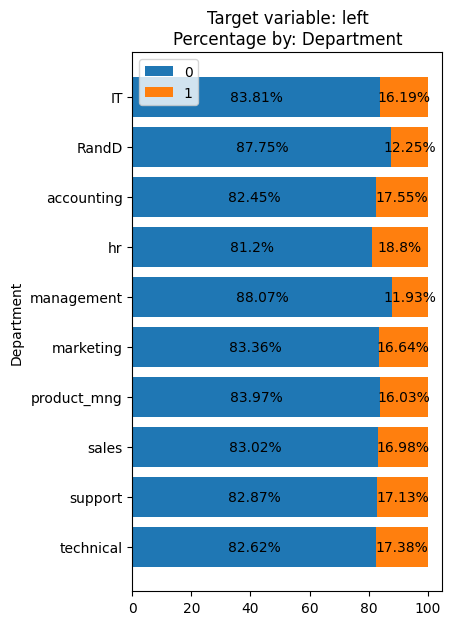

In [18]:
chart, subsets = percentage_analysis(base_df_2, ['Department'])

Our function also returns the data as a summarized dataframe, let's use it to investigate the distribution of the observed turnover rate.

In [19]:
summary = subsets['Department_True']
summary.rename(columns = {'1_percent':'Employee left = 1'}, inplace = True)
summary_desc = summary[['Employee left = 1']].describe()
summary_desc

,Employee left = 1
count,10.000000
mean,16.088000
std,2.245508
min,11.930000
25%,16.070000
50%,16.810000
75%,17.317500
max,18.800000


the HR and Management departments have the maximal and minimal turnover rate values with 18.8% and 11.93% respectively, the interquartile range equals 1.23 (17.31-16.07). The difference between the mean and the median (16.08 - 16.81 =-0.73) seems to be driven by outliers (in particular, the lower values) the std value is impacted  by this as well.

Text(0.5, 0, 'Observed Percentage')

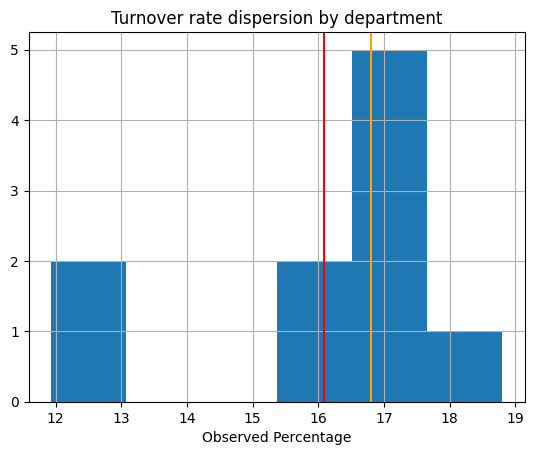

In [20]:
hist_chart = summary['Employee left = 1'].hist(bins=6, grid=True)
hist_chart.axvline(x = summary_desc.iloc[1].values[0], color = 'red')
hist_chart.axvline(x = summary_desc.iloc[5].values[0], color = 'orange')
plt.title('Turnover rate dispersion by department')
plt.xlabel('Observed Percentage') 

Having confirmed the differences by department, let's now inspect the overall left percentage differeces by the categorical variables:

* number_project.
* salary
* work_accident
* Promotion_last_5years


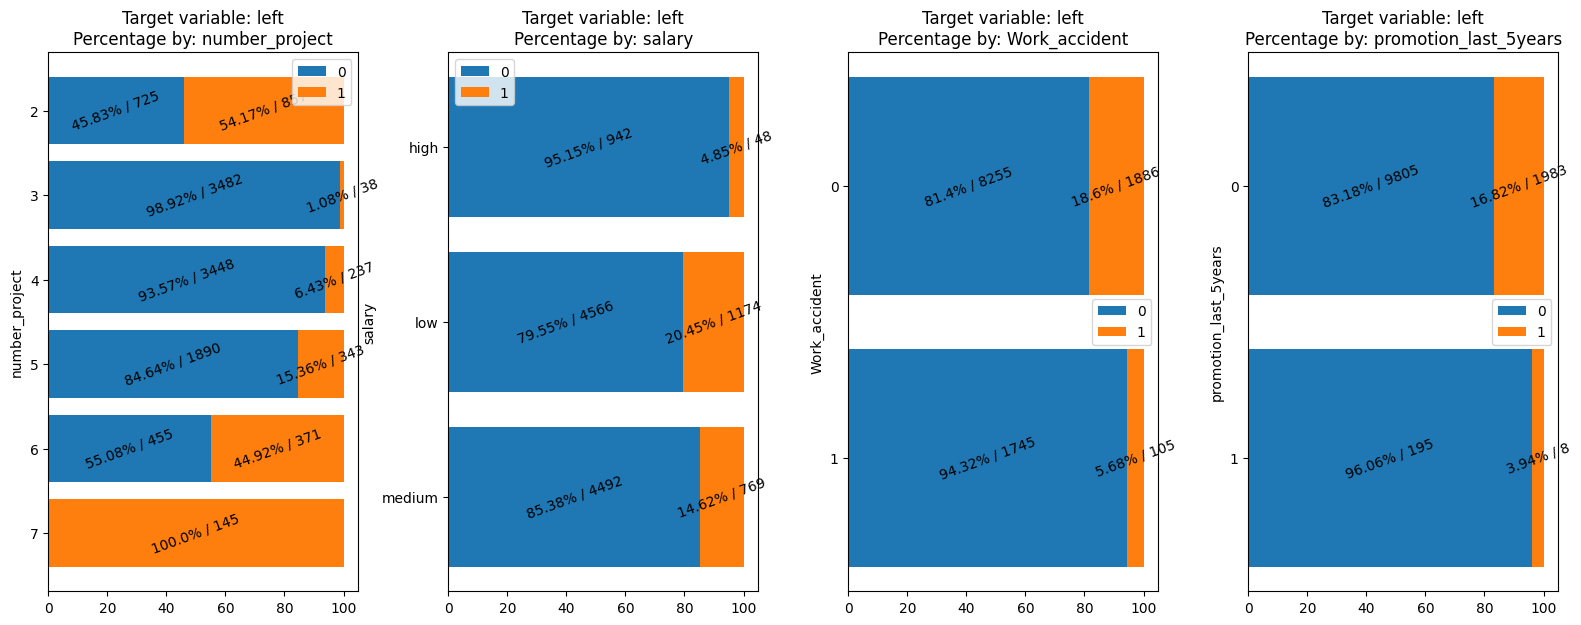

In [21]:
chart, subsets = percentage_analysis(base_df_2, ['number_project', 'salary', 'Work_accident', 'promotion_last_5years'], label_type = 2, rot = 20)	

The 4 features above have a significant overall effect over the turnover rate. some observations from the chart above are:
* **number_project**, defined as "Number of projects employee contributes to" (seems to be a direct indicator of the amount of work an employee has) shows that employees contributing to 2, 6 and 7 projects have a higher turnover rate. the 100% of employees contributing to 7 projects (145 observations) left the company.  
* **salary**, as we could expect, employees having low salary have the higher turnover rate (20.45%), then medium (14.62%) and lastly high salary (4.85%).
* **work_accident**, it seems that employees that did not had a work accident have the highest turnover rate.
* **promotion_last_5years**, from the small amount of employees that got a promotion over the last 5 years, only 8 (3.94%) left the company. 

let's now inspect the differences by the numerical values that we transformed to quartiles:

* satisfaction_level_quartile
* last_evaluation_quartile.
* average_montly_hours_quartile

And lets also include the column "time_spend_company" as it is.

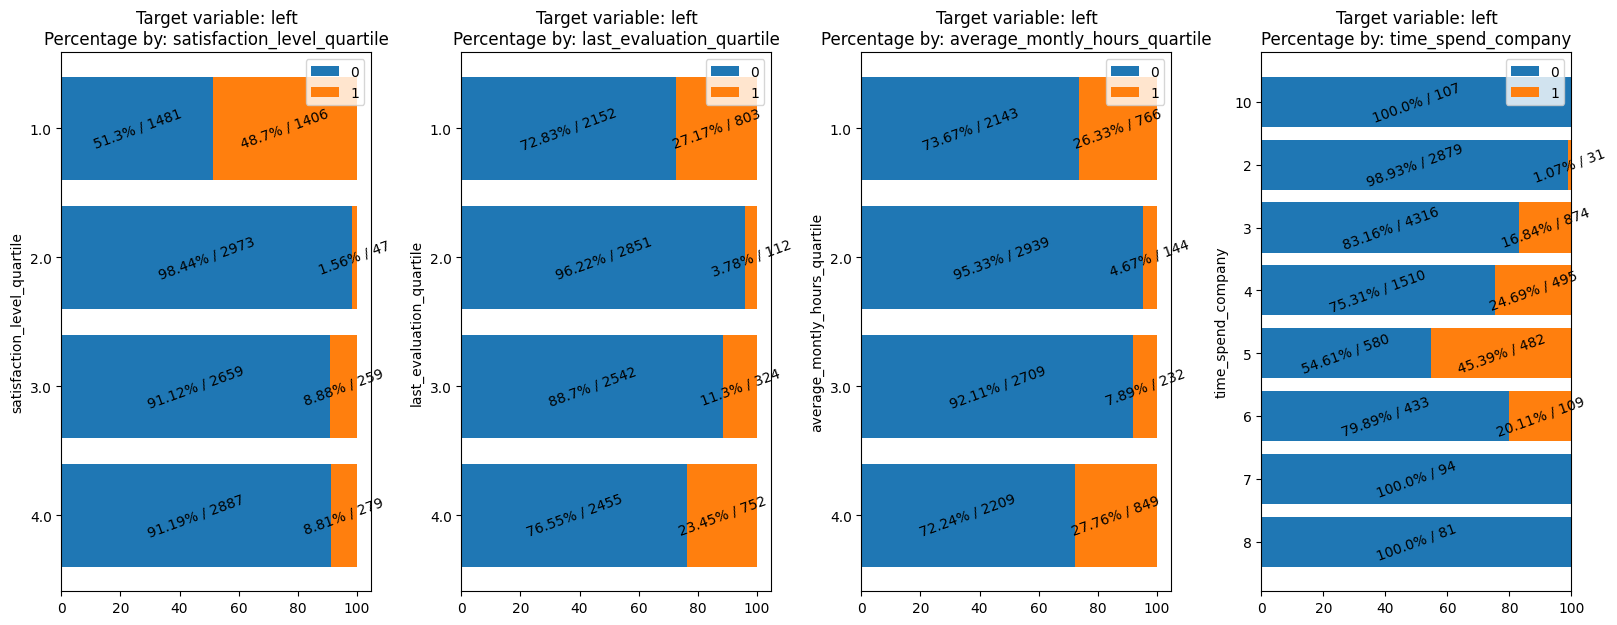

In [22]:
chart, subsets = percentage_analysis(base_df_2, ['satisfaction_level_quartile', 'last_evaluation_quartile', 'average_montly_hours_quartile', 'time_spend_company'],label_type = 2, rot = 20)				

Some observations from the chart above are:

* **satisfaction_level**, defined as "Employee-reported job satisfaction level 0-1", shows asignificant differences in turnover rate based on quartiles, 1406 employees (48.7%) of the employees included on this category (satisfaction level between 0.09 to 0.43) left the company. Considering that the amount of employees who left the company is 1991 in the entire dataset there is no question that this feature is a key feature to predict turnover.
* **last_evaluation_quartile**, shows that most of the employees that left the company where inside the first and last interval, in other word had the lowest and highest values.
* **average_montly_hours_quartile**, show a similar pattern as the previous feature last_evaluation_quartile and number_project.
* **time_spend_company**, it seems like employees having a tenure of 4 to 6 years have the higher turnover rates.

Knowing that the **number_project** field previously explored revealed significant differences in rate within its levels, let's repeat the previous chart, but this time creating subplots by each of the number_project values to investigate the differences, this chart will allow us to understand in greater detail what we've found so far.

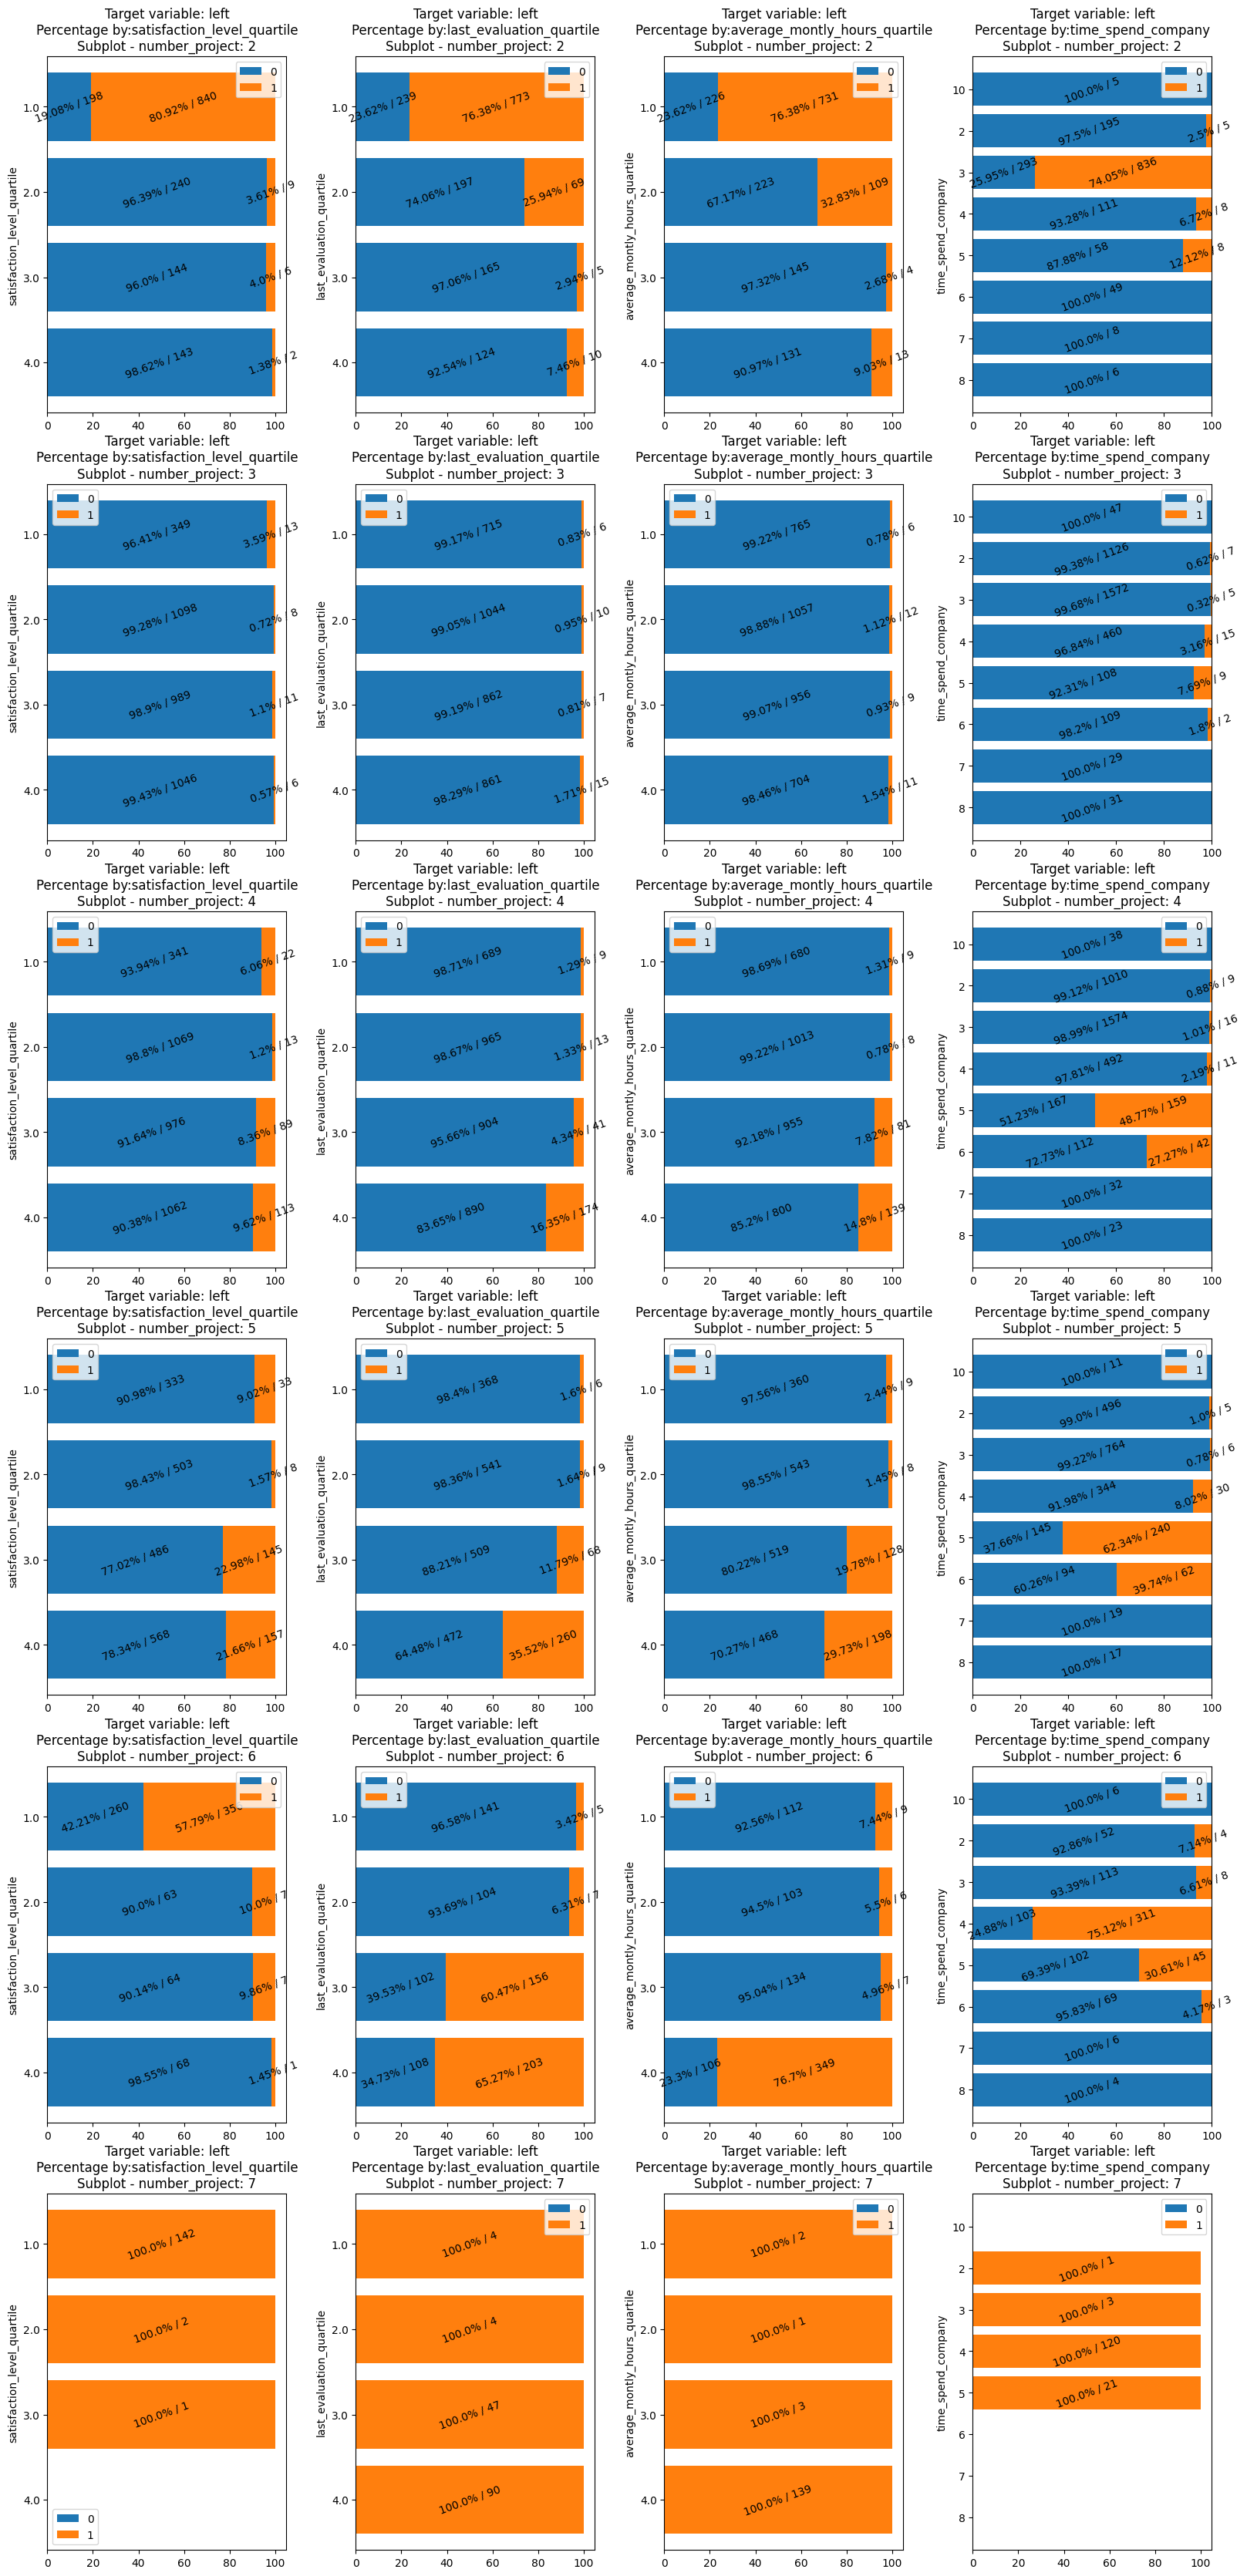

In [23]:
chart, subsets = percentage_analysis(base_df_2, ['satisfaction_level_quartile', 'last_evaluation_quartile', 'average_montly_hours_quartile', 'time_spend_company'],grid_column = 'number_project', label_type = 2, rot = 20)

As we have previously discovered, employees contributing to 2, 6 and 7 projects have the higher turnover rates, the chart above helped us identify the following:

* Most of the employees that left the company while contributing only to 2 projects had the lower levels of satisfaction, evaluation scores and average monthly hours. Also, most of them had a tenure of three years. 
* On the contrary, most of the employees that left the company while contributing to 6 and 7 projects had the higher evaluation scores and monthly hours, but similar than the previous group, they mostly had low satisfaction levels. Most members of this group had a tenure of 4 years. 
* The employees that left the company while contributing to 3 to 5 projects had high satisfaction levels, evaluation scores and monthly hours, most of them have a tenure of 5 and 6 years.

Why would the third group leave the company? they had less than 6 projects, had good evaluation scores and their satisfaction level was high. Let's filter this group to investigate further. 

In [24]:
df2a = base_df_2[(base_df_2['number_project'].isin([3,4,5])) & (base_df_2['left'] == 1) & (base_df_2['time_spend_company'].isin([5,6]))].groupby(['salary', 'promotion_last_5years', 'Work_accident']).agg({'left':'count'})
df2b = base_df_2[(base_df_2['number_project'].isin([3,4,5])) & (base_df_2['left'] == 0)& (base_df_2['time_spend_company'].isin([5,6]))].groupby(['salary', 'promotion_last_5years', 'Work_accident']).agg({'left':'count'})
df2a = df2a.join(df2b, lsuffix='_1', rsuffix='_0')
df2a['left_percent'] = round(df2a['left_1'] / (df2a['left_1'] + df2a['left_0'])*100,2)
df2a

left_1  left_0  left_percent
salary promotion_last_5years Work_accident                              
high   0                     0                  13      54         19.40
low    0                     0                 289     251         53.52
                             1                   8      61         11.59
medium 0                     0                 185     281         39.70
                             1                  18      66         21.43
       1                     1                   1       3         25.00

the column 'left_1' has the count of employees that left the company, the dataframe filters employees that contributed to 3 to 5 projects, and had a tenure of 5 and 6 years. The combination of promotion_last_5years = 0 and Work_accident = 0 has the higher turnover rates.

Let's create one more series of plots, this time using the **satisfaction_level_quartile** as value to divide our varibles, also, lets split the data by employees that have left the company and those who haven't. To avoid a confusing chart for the overlapping labels, lets simply remove them for this chart.

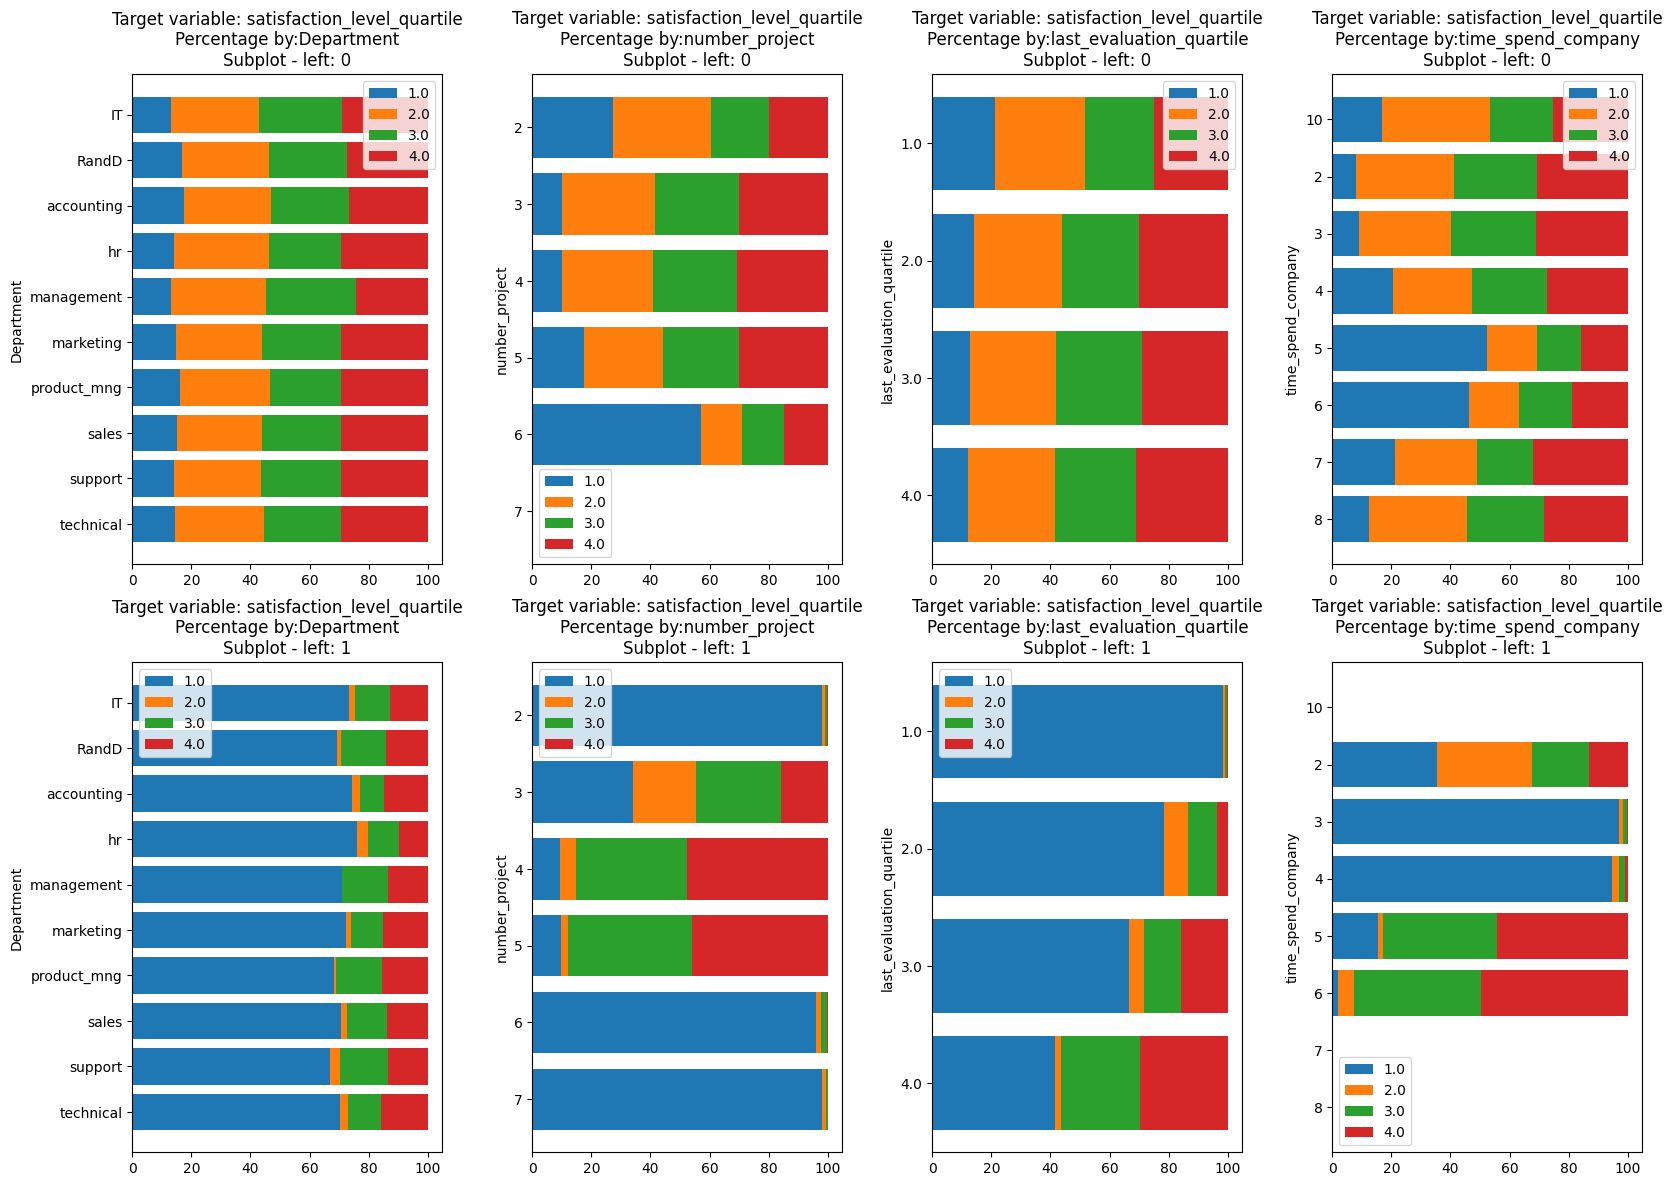

In [25]:
chart, subsets = percentage_analysis(base_df_2, ['Department','number_project','last_evaluation_quartile', 'time_spend_company'], grid_column = 'left', variable = 'satisfaction_level_quartile', label_type = 0)	

As for our exploration of the dataset we know that there are three groups of employees that are likely to leave the company:

* **group 1**: Employees who contribute to a small amount of projects and low evaluation scores.
* **group 2**: Employees with 6 or more projects, high evaluation scores and low satisfaction levels.
* **group 3**: employees with a tenure of 5 and 6 years, high evaluation scores and satisfaction level but no promotions during the last 5 years or work accidents. 

The groups are easily visible if we plot satisfaction_level and average_montly_hours.

<AxesSubplot: xlabel='satisfaction_level', ylabel='average_montly_hours'>

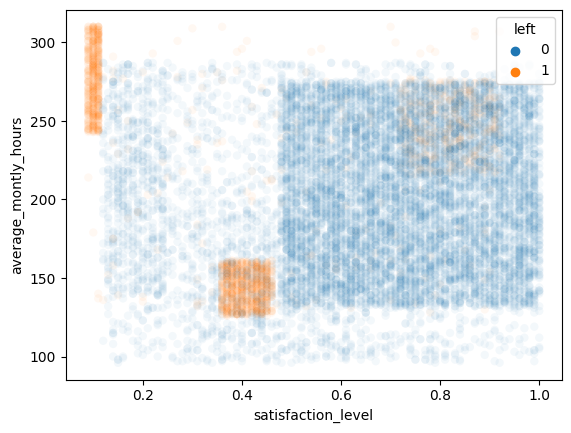

In [26]:
sns.scatterplot(base_df_2, x="satisfaction_level", y="average_montly_hours", hue="left", alpha=0.05)

We can see 4 main clusters, three of them (label left = 1), represents our target population, one of them resides within the forth cluster (blue box) made of employees that have not left the company and its likely to be the greatest challenge for the ML model.

## Model Construction.

With the knowledge we gathered, let's prepare the our environment to create the ML model.

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve

Let's prepare one more auxiliary function to avoid repetitive code

In [28]:
def perform_logistic_regression(df, target_feature = 'left', test_size = 0.25):
    """
    Description: 
        The function receives a dataset and a target column and performs a logistic regression
    Arguments:
        df: a pandas dataset.
        target_feature: the variable to be predicted, default: left
        test_size: determines the learn-test split size. Default: 0.25
    """
    y = df[target_feature]
    X = df.drop(target_feature, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)
    log_clf = LogisticRegression(random_state=42, max_iter=500).fit(X_train, y_train)
    y_pred = log_clf.predict(X_test)
    log_cm = confusion_matrix(y_test, y_pred, labels=log_clf.classes_)
    log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=log_clf.classes_)
    log_disp.plot(values_format='')
    plt.show()
    target_names = ['Predicted would not leave', 'Predicted would leave']
    print(classification_report(y_test, y_pred, target_names=target_names))
    return log_clf, X_train, X_test, y_train, y_test, y_pred

### Logistic Regression - simple.

As mentioned earlier, there is a well know optimal solution for this problem, you are free to review that solution [here](https://www.coursera.org/learn/google-advanced-data-analytics-capstone). In this notebook I'll try to come up with an alternative solution by improving the basic logistic regression model performance. 

Let's start by creating a simple model that we will use as a reference. The steps we'll follow are:

* Create a copy of the initial dataset, the duplicated rows have been already removed.
* The feature 'salary' has to be converted to an ordinal categorical variable.
* The 'time_spend_company' has outliers that can impact the performace of the model, thus we'll remove them by using the IQR rule as reference. 

In [29]:
df_lg1 = base_df.copy()
df_lg1['salary'] = (df_lg1['salary'].astype('category').cat.set_categories(['low', 'medium', 'high']).cat.codes)
df_lg1 = pd.get_dummies(df_lg1, drop_first=False)
df_lg1 = df_lg1[(df_lg1['time_spend_company'] >= lower_limit) & (df_lg1['time_spend_company'] <= upper_limit)]
df_lg1.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,Department_IT,Department_RandD,Department_accounting,Department_hr,Department_management,Department_marketing,Department_product_mng,Department_sales,Department_support,Department_technical
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
5,0.41,0.50,2,153,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0


The next cells will:

* Create a subset called X representing the transformed dataset removing the target feature "left"
* Create a subset called y having only the target feature "left".
* Split X and y into the test and train subsets.
* Fit the data ito the regression model.
* Build a confusion matrix to visually see the performance of the model againts the test data.
* Build a classification report to inspect our key KPIs.

The KPIs we'll consider for evaluation are:

* Accuracy = TP + TN / TP + TN + FP + FN
* Precision = TP / TP + FP
* Recall = TP / TP + FN
* F1 = 2(TP) / 2(TP) + FP + FN

As a refresher:

* TP = True Positive.
* FP = False Positive.
* TN = True Negative.
* FN = False Negative.

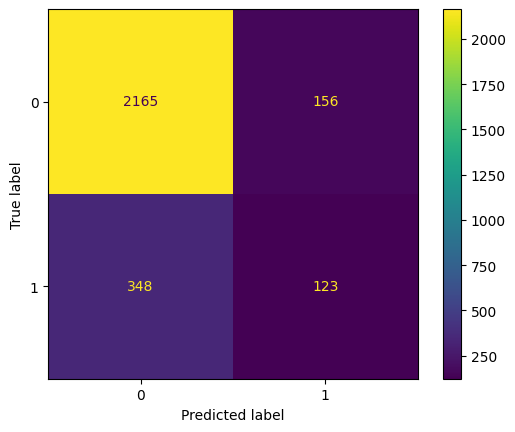

                           precision    recall  f1-score   support

Predicted would not leave       0.86      0.93      0.90      2321
    Predicted would leave       0.44      0.26      0.33       471

                 accuracy                           0.82      2792
                macro avg       0.65      0.60      0.61      2792
             weighted avg       0.79      0.82      0.80      2792



In [30]:
log_clf, X_train, X_test, y_train, y_test, y_pred = perform_logistic_regression(df_lg1)

The 0.82 accuracy level is deceiving and mostly driven by the model's performance on predicting true negatives. if we focus on the model's ability to predict employees that left the company the performance is poor with a 0.44 precision score (123/123+156 = 0.44) and 0.26 recall score  (123/123+348 = 0.26).

### Logistic Regression - Feature engineering.

Having confirmed the model's low performance while processing the data as it is, let's try to enhance the performace by engineering a new feature, let's simply call it "leave_score". First let's create a new copy of the base dataset.

In [31]:
df_lg2 = base_df.copy()

Following our observations on the EDA section above, let's create a new column that we will call "group" that will represent the main "clusters" already described.

In [32]:
df_lg2.loc[(base_df['left'] == 1) & (df_lg2['satisfaction_level'] < 0.5) & (df_lg2['average_montly_hours'] < 175), 'group'] = '1'
df_lg2.loc[(base_df['left'] == 1) & (df_lg2['satisfaction_level'] < 0.5) & (df_lg2['average_montly_hours'] >= 175), 'group'] = '2'
df_lg2.loc[(base_df['left'] == 1) & (df_lg2['satisfaction_level'] >= 0.5) & (df_lg2['average_montly_hours'] > 200), 'group'] = '3'
df_lg2.loc[base_df['left'] == 0 , 'group'] = '4'

Now, the idea is to create a score that, the higher the value, the more likely is an employee to leave the company, and to do so we'll use what we know by now, for example:
* There are features like 'satisfaction_level', 'average_montly_hours' and 'last_evaluation' where the groups with the higher and lower values had a greater turnover rate.
* Employees with high salary are less likely to leave the company than employees with medium and low salary.
* Employees that had an accident are less likely to leave than those who did.
* Employees who had a promotion in the last 5 years are less likely to leave the company than those who doesn't.
* Employees contributing with 2, 6 and 7 projects are more likely to leave the company.
* Employees with a tenure of 5 years are more likely to leave the company followed by tenure of 4, 3 and 6 years, other values shows smaller turnover rates. 

For 'satisfaction_level', 'average_montly_hours' and 'last_evaluation' let's standardize their values using our previously designed function. 'satisfaction_level' will simply be used with the opposite sign, as higher values represents less likihood to leave the company (thus a negative amount is more representative) while a negative standardized value can be associates with a greater chance of leaving. For  'average_montly_hours' and 'last_evaluation' we'll use the absolute standard value, as the greater the difference from the mean (0) the greater the chance of leaving the company. For the features 'salary', 'Work_accident', 'promotion_last_5years', 'number_project' and 'time_spend_company', we will directly map the existing values to a score, for example, high salary = 0 for being associated with a low turnover rate then medium = 1 and low = 2. 

The cell will define these scores and display the first 5 rows of the dataset for inspection.

In [33]:
df_lg2 = convert_to_zscore(df_lg2, target_col = ['satisfaction_level', 'average_montly_hours', 'last_evaluation'])
df_lg2['salary_score']= df_lg2['salary'].map({'low':2,'medium':1,'high':0})
df_lg2['work_accident_score']= df_lg2['Work_accident'].map({0:1,1:0})
df_lg2['promotion_last_5years_score']= df_lg2['promotion_last_5years'].map({0:1,1:0})
df_lg2['number_project_score']= df_lg2['number_project'].map({2:5,3:0,4:0,5:3,6:5,7:7})
df_lg2['time_spend_company_score']= df_lg2['time_spend_company'].map({2:0,3:1,4:2,5:4,6:2,7:1,8:0,9:0,10:0})
df_lg2.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary,group,satisfaction_level_standardized,average_montly_hours_standardized,last_evaluation_standardized,salary_score,work_accident_score,promotion_last_5years_score,number_project_score,time_spend_company_score
0,0.38,0.53,2,157,3,0,1,0,sales,low,1,-1.035625,-0.892171,-1.108944,2,1,1,5,1
1,0.80,0.86,5,262,6,0,1,0,sales,medium,3,0.706608,1.262656,0.851344,1,1,1,3,2
2,0.11,0.88,7,272,4,0,1,0,sales,medium,2,-2.155631,1.467878,0.970150,1,1,1,7,2
3,0.72,0.87,5,223,5,0,1,0,sales,low,3,0.374754,0.462292,0.910747,2,1,1,3,4
4,0.37,0.52,2,159,3,0,1,0,sales,low,1,-1.077107,-0.851126,-1.168347,2,1,1,5,1


The final 'leave_score' is simply the sum of all of our independent scores.

In [34]:
df_lg2['leave_score'] = -(df_lg2['satisfaction_level_standardized']) +\
                            abs(df_lg2['last_evaluation_standardized']) +\
                            abs(df_lg2['average_montly_hours_standardized'])+\
                            df_lg2['salary_score'] +\
                            df_lg2['work_accident_score'] +\
                            df_lg2['number_project_score'] +\
                            df_lg2['promotion_last_5years_score'] +\
                            df_lg2['time_spend_company_score']

Having defined the new feature let's inspect how it is different between our two employee groups.

In [35]:
leave_score_summary = df_lg2.groupby('left').agg({'leave_score':['mean','min','max','std']})
leave_score_summary

leave_score                              
            mean      min        max       std
left                                          
0       6.854953  0.44839  18.368268  2.887445
1      12.736268  3.41193  20.236775  2.664123

In [36]:
leave_score_summary[('leave_score', 'mean')][0] - leave_score_summary[('leave_score', 'mean')][1]

-5.881314856141378

The mean value is significantly different as we would expect, lets see how the 3 groups of employees that left the company are represented in our new feature. Let's use a low alpha value to see where the scores tend to accumulate.

Text(0.5, 0, 'leave_score')

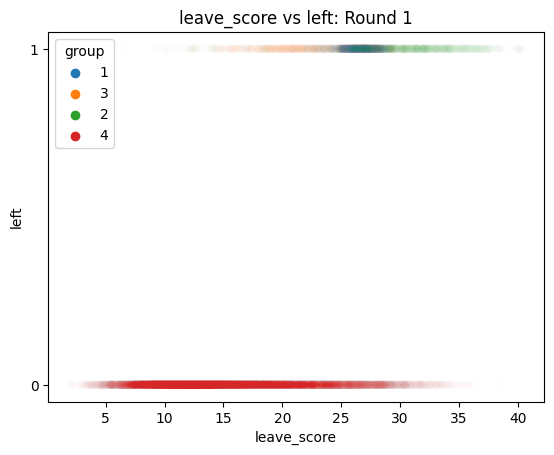

In [56]:
sns.scatterplot(df_lg2, x="leave_score", y=df_lg2["left"].astype(str),alpha=0.01,  hue="group")
plt.title('leave_score vs left: Round 1')
plt.xlabel('leave_score') 

As a refresher, group 1 represents employees who contribute to a small amount of projects and have low evaluation scores and group 2 represents employees with 6 and 7 projects with low satisfaction level, these two groups have the higher values and for the model it would be easy to predict turnover if this was all the case. Group 3 is a challenge, because these are the employees who left the company having high satisfaction levels and high evaluation scores thus, they scores are more in the middle - left end of the scale. Group 4 did not left the company. Let's use seaborn regplot to see a visual representation of the model. 

<AxesSubplot: xlabel='leave_score', ylabel='left'>

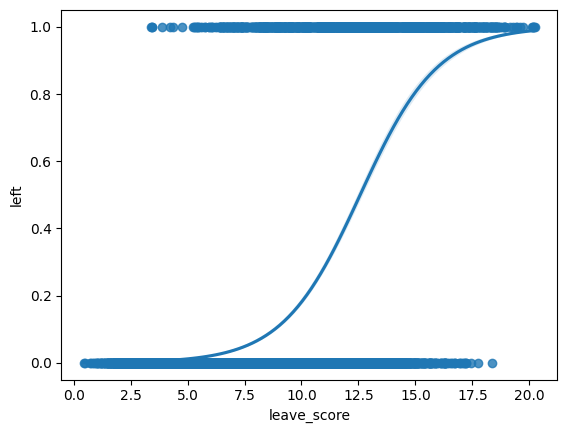

In [38]:
sns.regplot(df_lg2, x='leave_score', y='left', logistic=True)

Let's rerun the regression model, this time we only need to pass two columns, 'leave' and 'leave_score'.

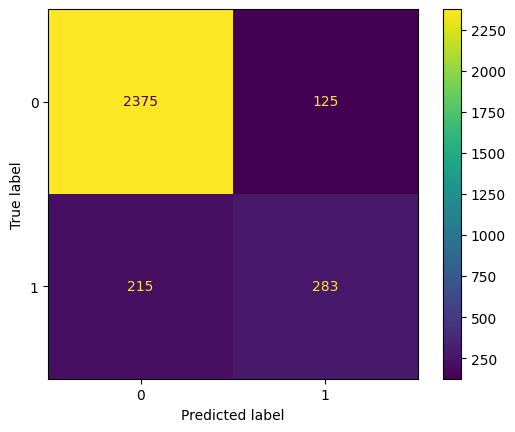

                           precision    recall  f1-score   support

Predicted would not leave       0.92      0.95      0.93      2500
    Predicted would leave       0.69      0.57      0.62       498

                 accuracy                           0.89      2998
                macro avg       0.81      0.76      0.78      2998
             weighted avg       0.88      0.89      0.88      2998



In [39]:
log_clf, X_train, X_test, y_train, y_test, y_pred = perform_logistic_regression(df_lg2[['leave_score','left']])

It seems like this model performs significantly better, however we didn't predicted almost half of the true positives on the test data.

It is reasonable to think that the multiple independent scores may have different levels of relevance in the overall leave_score value, for example, the values may not change too much if change how the promotion feature works, but we'll see a completely new distribution if we change how the monthly avegare work hours works. The next cell will help us investigate how giving more relevance to our independent scores alters the difference in mean between the two groups of employees by running a series of iterations, the idea is to multiply each score from 0 to 4 (65536 total combinations), then will get the combination of relevance values that provides the greater difference in mean between groups to use it in our next model. The difference in mean values needs to be measured on a standardized scale, otherwise we are only companing the increase in scale which we already knows it will happen.

In [40]:
df_lgt = df_lg2.copy()
relevance_levels = 4
summary = {'satisfaction_level':[], 'average_montly_hours':[], 'number_project':[], 'salary':[], 'work_accident':[],'promotion':[],'time_spend':[],'last_evaluation':[], 'mean_difference':[]}
for satisfaction_level in range(relevance_levels):
    for average_montly_hours in range(relevance_levels):
        for number_project in range(relevance_levels):
            for salary_score in range(relevance_levels):
                for work_accident in range(relevance_levels):
                    for promotion in range(relevance_levels):
                        for time_spend in range(relevance_levels):
                            for last_evaluation in range(relevance_levels):
                                df_lgt['leave_score'] = -(df_lgt['satisfaction_level_standardized'] * satisfaction_level) +\
                                                            abs(df_lgt['last_evaluation_standardized'] * last_evaluation) +\
                                                            abs(df_lgt['average_montly_hours_standardized'] * average_montly_hours)+\
                                                            (df_lgt['number_project_score']*number_project) +\
                                                            (df_lgt['salary_score']*salary_score) +\
                                                            (df_lgt['work_accident_score']*work_accident) +\
                                                            (df_lgt['promotion_last_5years_score'] * promotion) +\
                                                            (df_lgt['time_spend_company_score']*time_spend)
                                df_lgt = convert_to_zscore(df_lgt, target_col = ['leave_score'])
                                leave_coef_grouped = df_lgt.groupby('left').agg({'leave_score_standardized':['mean']})
                                mean_diff = leave_coef_grouped[('leave_score_standardized', 'mean')][0] - leave_coef_grouped[('leave_score_standardized', 'mean')][1]
                                summary['satisfaction_level'].append(satisfaction_level)
                                summary['average_montly_hours'].append(average_montly_hours)
                                summary['number_project'].append(number_project)
                                summary['salary'].append(salary_score)
                                summary['work_accident'].append(work_accident)
                                summary['promotion'].append(promotion)
                                summary['time_spend'].append(time_spend)
                                summary['last_evaluation'].append(last_evaluation)
                                summary['mean_difference'].append(mean_diff)
summary_df = pd.DataFrame(summary).sort_values(by = 'mean_difference', ascending=True).reset_index()
summary_df.head()

,index,satisfaction_level,average_montly_hours,number_project,salary,work_accident,promotion,time_spend,last_evaluation,mean_difference
0,31211,1,3,2,1,3,2,2,3,-1.650547
1,31195,1,3,2,1,3,1,2,3,-1.650330
2,31227,1,3,2,1,3,3,2,3,-1.650195
3,31147,1,3,2,1,2,2,2,3,-1.649883
4,31131,1,3,2,1,2,1,2,3,-1.649635


This is the best combination found.

In [41]:
best_comb = summary_df[:1]
best_comb

,index,satisfaction_level,average_montly_hours,number_project,salary,work_accident,promotion,time_spend,last_evaluation,mean_difference
0,31211,1,3,2,1,3,2,2,3,-1.650547


Let's recalculate 'leave_score' using the relevence combination that we found causes the greater difference in mean values and pull a new summary.

In [42]:
df_lg2['leave_score'] = -(df_lg2['satisfaction_level_standardized'] * best_comb['satisfaction_level'][0]) +\
                        abs(df_lg2['last_evaluation_standardized'] * best_comb['last_evaluation'][0]) +\
                        abs(df_lg2['average_montly_hours_standardized'] * best_comb['average_montly_hours'][0]) +\
                        abs(df_lg2['number_project_score']*best_comb['number_project'][0]) +\
                        (df_lg2['salary_score']*best_comb['salary'][0]) +\
                        (df_lg2['work_accident_score']*best_comb['work_accident'][0]) +\
                        (df_lg2['promotion_last_5years_score'] * best_comb['promotion'][0]) +\
                        (df_lg2['time_spend_company_score'] * best_comb['time_spend'][0])

In [43]:
leave_score_summary = df_lg2.groupby('left').agg({'leave_score':['mean','min','max','std']})
leave_score_summary

leave_score                               
            mean       min        max       std
left                                           
0      14.953789  2.027452  38.286883  5.599299
1      26.385953  6.763907  40.316098  4.739714

The following graph shows our 4 groups, their new distribution and their means.

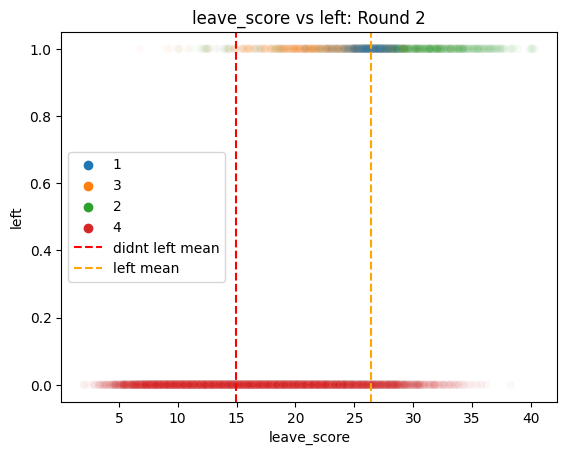

In [45]:
sns.scatterplot(df_lg2, x="leave_score", y=df_lg2["left"].astype(str), alpha=0.03,  hue="group")
plt.title('leave_score vs left: Round 2')
plt.xlabel('leave_score') 
plt.axvline(leave_score_summary[('leave_score', 'mean')][0], color = 'red', linestyle ="--", label = 'didnt left mean')
plt.axvline(leave_score_summary[('leave_score', 'mean')][1], color = 'orange', linestyle ="--", label = 'left mean')
plt.legend(loc='center left')

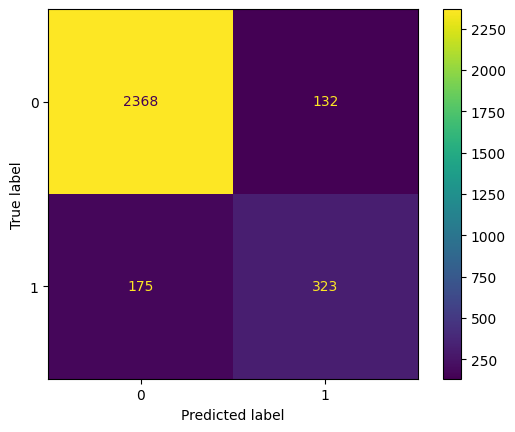

                           precision    recall  f1-score   support

Predicted would not leave       0.93      0.95      0.94      2500
    Predicted would leave       0.71      0.65      0.68       498

                 accuracy                           0.90      2998
                macro avg       0.82      0.80      0.81      2998
             weighted avg       0.89      0.90      0.90      2998



In [46]:
log_clf, X_train, X_test, y_train, y_test, y_pred = perform_logistic_regression(df_lg2[['leave_score','left']])

This model shows an improvement on detected true positives, the recall and precision scores are higher compared to the two previous models. The amount of false positives increments but not significantly.

Finally let's test how the model performs on multiple probability threshold values and see which one has the best performance. 

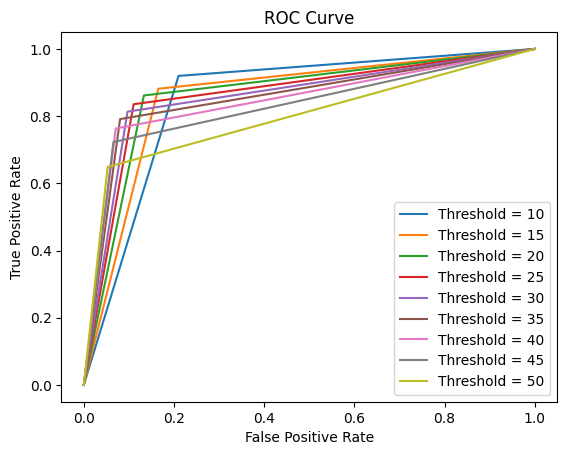

In [47]:
roc_scores_dict = {'threshold':[], 'roc_auc_score':[]}
for i in range(10,55,5):
    pt = i/100
    fpr, tpr, thresholds = roc_curve(y_test, (log_clf.predict_proba(X_test)[:, 1] >=pt).astype(int))
    score = roc_auc_score(y_test, (log_clf.predict_proba(X_test)[:, 1] >=pt))
    roc_scores_dict['threshold'].append(pt)
    roc_scores_dict['roc_auc_score'].append(str(score))
    plt.plot(fpr, tpr, label = f'Threshold = {i}') 
ROC_summary = pd.DataFrame(roc_scores_dict)
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('ROC Curve') 
plt.legend() 
plt.show()

In [48]:
ROC_summary.sort_values(by = 'roc_auc_score', ascending = False, inplace = True)
ROC_summary.reset_index()
best_threshold = ROC_summary[:1]['threshold']

In [49]:
ROC_summary

,threshold,roc_auc_score
2,0.20,0.8641228915662651
3,0.25,0.8624706827309236
4,0.30,0.8582265060240963
1,0.15,0.8581630522088353
5,0.35,0.8553823293172691
0,0.10,0.8548393574297188
6,0.40,0.8461261044176709
7,0.45,0.8286457831325301
8,0.50,0.7978971887550201


It seems like a threshold of 0.20 has the higher AUC value, let's rebuild our confusion matrix using this threshold.

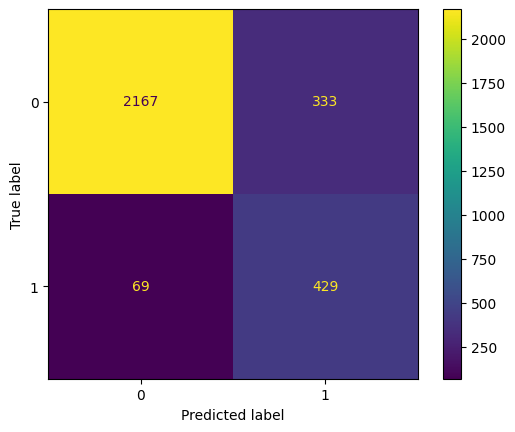

In [50]:
log_cm = confusion_matrix(y_test, (log_clf.predict_proba(X_test)[:, 1] >= float(best_threshold)).astype(int), labels=log_clf.classes_)
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=log_clf.classes_)
log_disp.plot(values_format='')
plt.show()

In [51]:
target_names = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_test, (log_clf.predict_proba(X_test)[:, 1] >= float(best_threshold)).astype(int), target_names=target_names))

                           precision    recall  f1-score   support

Predicted would not leave       0.97      0.87      0.92      2500
    Predicted would leave       0.56      0.86      0.68       498

                 accuracy                           0.87      2998
                macro avg       0.77      0.86      0.80      2998
             weighted avg       0.90      0.87      0.88      2998



it seems like at the expense of increasing the amount of false positives we were able to catch 86% of out target employees. This is the point where, depending on the company's priority the best model could be this or the previous one. If we prioritize precision, then the previous model is better, if we prioritize recall, this one is he one to go with.

## Conclusion

In the case this was a real company, some recomendations we could provide based on our analysis are:
* Investigate why the amount average work hours can be so different between employees. it can be easily cause a lot of dissatisfaction.
* Investigate and come up with a better approach to distribute the job, it is likely the the employees with 6 or 7 projects left due to exhaustion.
* Assuming that the employees with only 2 projects were not given more due lack of capacitity, it is likely the company needs to implement a better training program.
* The fact that a lot of employees left the company after 5 years seems to indicate some lack of recognition or grow opportunities.

As for the model:
* Unfortunately our model does not perform better than a decision tree based classifier which is the optimal solution for this problem, however we were able to improve its performance by engineering our own score, making it an alternative if computational demand represents a problem.